In [1]:
import os

# Set working directory to /root/Cycle/Github
os.chdir("/root/Cycle/Github")

# Print the current working directory
print("Current working directory:", os.getcwd())

import sys
sys.path.append("./HarmoCycle/")
from HarmoCycle import *
from Utils import calculate_gene_oscillation_properties_v2


Current working directory: /root/Cycle/Github


# Part1-1-Gene Expression vs Gene Frequency

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scanpy as sc
import warnings
from scipy.fft import fft, fftfreq

# Suppress scanpy warnings for cleaner output
warnings.filterwarnings("ignore")

# ================= Configuration =================
# Base directory for saving plots
SAVE_DIR = './FigurePlot/Dataset_FFT_Check'
os.makedirs(SAVE_DIR, exist_ok=True)

# Matplotlib settings
plt.rcParams['font.family'] = ['DejaVu Sans', 'Liberation Sans', 'sans-serif']
plt.rcParams['font.size'] = 10

# Dataset paths
DATASETS = {
    'mESC': './Dataset/mESC.h5ad',
    'hESC': './Dataset/hESC.h5ad',
    'hU2OS': './Dataset/hU2OS.h5ad',
    # Handle mESCQ path check
    'mESCQ': './Dataset/mESCQ.h5ad' if os.path.exists('./Dataset/mESCQ.h5ad') else './Dataset/mESCQ' 
}

# Target Cell Cycle Markers to analyze
TARGET_GENES = ['PCNA', 'TOP2A', 'CDK1', 'MKI67', 'POLR2A', 'SDHA', 'B2M', 'PGK1']

# ================= Core Functions =================

def calculate_fourier_spectrum(expression_values, sampling_rate=1.0):
    """
    Computes the Fourier Amplitude Spectrum for a 1D signal.
    """
    n = len(expression_values)
    
    # Remove DC component (mean) to focus on fluctuations
    expression_values = expression_values - np.mean(expression_values)
    
    # FFT calculation
    yf = fft(expression_values)
    xf = fftfreq(n, 1/sampling_rate)
    
    # Extract positive frequencies
    idx = np.arange(1, n//2)
    freqs = xf[idx]
    amplitudes = 2.0/n * np.abs(yf[idx])
    
    return freqs, amplitudes

def plot_gene_comparison(adata_ordered, adata_shuffled, gene_name='PCNA', 
                        dataset_name='Dataset'):
    """
    Generates a 2x2 comparison plot: Ordered vs Shuffled expression and their spectra.
    """
    
    # 1. Check existence
    if gene_name not in adata_ordered.var_names:
        # Try case-insensitive search
        candidates = [g for g in adata_ordered.var_names if g.upper() == gene_name.upper()]
        if candidates:
            gene_name = candidates[0]
        else:
            print(f"  ⚠️ Warning: Gene {gene_name} not found in {dataset_name}. Skipping.")
            return

    # 2. Extract Data
    def get_data(adata, g):
        X = adata[:, g].X
        if hasattr(X, "toarray"):
            return X.toarray().flatten()
        return X.flatten()

    expr_ordered = get_data(adata_ordered, gene_name)
    expr_shuffled = get_data(adata_shuffled, gene_name)
    
    # 3. Calculate FFT
    freqs_ordered, amps_ordered = calculate_fourier_spectrum(expr_ordered)
    freqs_shuffled, amps_shuffled = calculate_fourier_spectrum(expr_shuffled)
    
    # 4. Setup Figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Define colors
    color_ordered = '#2E86AB'  # Blue-ish
    color_shuffled = '#A23B72' # Red-ish
    
    # --- Unified Axis Limits for Fair Comparison ---
    # Expression Y-limits
    expr_min = min(expr_ordered.min(), expr_shuffled.min())
    expr_max = max(expr_ordered.max(), expr_shuffled.max())
    expr_padding = (expr_max - expr_min) * 0.1
    expr_ylim = (expr_min - expr_padding, expr_max + expr_padding)
    
    # Amplitude Y-limits
    amp_max = max(amps_ordered.max(), amps_shuffled.max()) if len(amps_ordered) > 0 else 1.0
    amp_padding = amp_max * 0.1
    amp_ylim = (0, amp_max + amp_padding)
    
    # --- Plotting ---
    
    # B1: Ordered Expression
    ax = axes[0, 0]
    ax.plot(expr_ordered, color=color_ordered, linewidth=1.5, alpha=0.9)
    ax.set_title(f'Ordered Expression\n(Sorted by Ground Truth)', fontweight='bold')
    ax.set_xlabel('Cell Index')
    ax.set_ylabel('Expression (Log1p)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(expr_ylim)
    
    # B2: Shuffled Expression
    ax = axes[0, 1]
    ax.plot(expr_shuffled, color=color_shuffled, linewidth=1.5, alpha=0.9)
    ax.set_title(f'Shuffled Expression\n(Randomized Order)', fontweight='bold')
    ax.set_xlabel('Cell Index')
    ax.set_ylabel('Expression (Log1p)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(expr_ylim)
    
    # B3: Ordered Spectrum
    ax = axes[1, 0]
    if len(amps_ordered) > 0:
        dominant_idx = np.argmax(amps_ordered)
        dominant_freq = freqs_ordered[dominant_idx]
        ax.plot(freqs_ordered, amps_ordered, color=color_ordered, linewidth=2)
        ax.axvline(dominant_freq, color='red', linestyle='--', alpha=0.7,
                  label=f'Peak: {dominant_freq:.3f}')
        ax.legend(loc='upper right')
    ax.set_title(f'Fourier Spectrum (Ordered)', fontweight='bold')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 0.2) # Focus on low frequencies where cycles occur
    ax.set_ylim(amp_ylim)
    
    # B4: Shuffled Spectrum
    ax = axes[1, 1]
    ax.plot(freqs_shuffled, amps_shuffled, color=color_shuffled, linewidth=2)
    ax.set_title(f'Fourier Spectrum (Shuffled)', fontweight='bold')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 0.2)
    ax.set_ylim(amp_ylim)
    
    # Global Title
    plt.suptitle(f'Gene: {gene_name} | Dataset: {dataset_name}\nSignal vs Noise Comparison', 
                fontsize=14, fontweight='bold', y=0.96)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    # Save PNG
    dataset_folder = os.path.join(SAVE_DIR, dataset_name)
    os.makedirs(dataset_folder, exist_ok=True)
    save_path = os.path.join(dataset_folder, f'{dataset_name}_{gene_name}_comparison.png')
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  [Saved] {save_path}")
    plt.close()

def sort_by_cell_cycle(adata):
    """
    Sorts the AnnData object based on Ground Truth labels ('true' column).
    """
    if 'true' not in adata.obs.columns:
        print("  ⚠️ Warning: Column 'true' not found in adata.obs. Skipping sort!")
        print(f"     Available columns: {list(adata.obs.columns)}")
        return adata

    print("  Sorting by ground-truth labels ('true' column)...")
    
    # Sort indices based on the 'true' column
    # Assuming 'true' is numeric or a sortable phase string
    sorted_indices = adata.obs.sort_values(by='true').index
    
    return adata[sorted_indices].copy()

def create_shuffled_adata(adata, random_seed=42):
    """
    Creates a randomly permuted copy of the AnnData object.
    """
    shuffled_adata = adata.copy()
    np.random.seed(random_seed)
    perm = np.random.permutation(adata.n_obs)
    shuffled_adata = shuffled_adata[perm]
    return shuffled_adata

# ================= Main Execution Loop =================

def main():
    print(f"Starting Analysis...")
    print(f"Results will be saved to: {SAVE_DIR}\n")
    
    for name, path in DATASETS.items():
        print(f"▶ Processing Dataset: {name}")
        
        # 1. Load
        if not os.path.exists(path):
            print(f"  ❌ File not found: {path}")
            continue
            
        try:
            adata = sc.read(path)
            if hasattr(adata.X, 'tocsr'):
                adata.X = adata.X.tocsr()
        except Exception as e:
            print(f"  ❌ Error loading: {e}")
            continue
            
        # 2. Preprocess
        print("  Preprocessing (Norm + Log1p)...")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        
        # 3. Sort (By 'true' label)
        adata_ordered = sort_by_cell_cycle(adata)
        
        # 4. Shuffle
        adata_shuffled = create_shuffled_adata(adata_ordered)
        
        # 5. Generate Plots per Gene
        print(f"  Plotting genes: {TARGET_GENES}")
        for gene in TARGET_GENES:
            plot_gene_comparison(
                adata_ordered, 
                adata_shuffled, 
                gene_name=gene, 
                dataset_name=name
            )
        print("-" * 30)

    print("\n✅ All analyses completed.")

if __name__ == "__main__":
    main()

Starting Analysis...
Results will be saved to: ./FigurePlot/Dataset_FFT_Check

▶ Processing Dataset: mESC
  Preprocessing (Norm + Log1p)...
  Sorting by ground-truth labels ('true' column)...
  Plotting genes: ['PCNA', 'TOP2A', 'CDK1', 'MKI67', 'POLR2A', 'SDHA', 'B2M', 'PGK1']
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_PCNA_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_TOP2A_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_CDK1_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_MKI67_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_POLR2A_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_SDHA_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_B2M_comparison.png
  [Saved] ./FigurePlot/Dataset_FFT_Check/mESC/mESC_PGK1_comparison.png
------------------------------
▶ Processing Dataset: hESC
  Preprocessing (Norm + Log1p)...
  Sorting by ground-truth labels ('true' column)...
  Plott

# Part1-2-Frequency Distribution

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scanpy as sc
from scipy import stats, sparse
from scipy.fft import fft, fftfreq
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Configuration and Paths
# ==============================================================================

# Base directory for saving figures
BASE_SAVE_DIR = './FigurePlot'
SUB_DIR = 'Freq_Distributions'
ROOT_SAVE_DIR = os.path.join(BASE_SAVE_DIR, SUB_DIR)

# Configure plotting style
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.2

# Dataset paths
DATASETS = {
    'mESC': './Dataset/mESC.h5ad',
    'hESC': './Dataset/hESC.h5ad',
    'hU2OS': './Dataset/hU2OS.h5ad',
    'mESCQ': './Dataset/mESCQ.h5ad' if os.path.exists('./Dataset/mESCQ.h5ad') else './Dataset/mESCQ'
}

# ==============================================================================
# 2. Gene Set Loading Function
# ==============================================================================

def load_prior_gene_sets():
    """
    Load prior gene sets from Seurat, Cyclebase, and KnowCCD.
    Returns a dictionary: {'Seurat': [...], 'Cyclebase': [...], 'KnowCCD': [...]}
    """
    gene_sets = {}
    print("Loading prior gene sets...")

    # 1. Seurat Genes
    try:
        df_seurat = pd.read_csv('./Dataset/SeuratCycleGenes.csv')
        gene_sets['Seurat'] = np.unique(df_seurat['Gene'].values)
        print(f"  - Seurat genes loaded: {len(gene_sets['Seurat'])}")
    except Exception as e:
        print(f"  [Warning] Failed to load Seurat genes: {e}")
        gene_sets['Seurat'] = []

    # 2. Cyclebase Genes
    try:
        cyclebase = pd.read_table('./Dataset/CyclebaseGeneList.txt')
        # Extract genes by cell cycle phase
        g1 = cyclebase[cyclebase['Peaktime'].str.contains('G1', na=False)].Genename.values
        g2 = cyclebase[cyclebase['Peaktime'].str.contains('G2', na=False)].Genename.values
        m = cyclebase[cyclebase['Peaktime'].str.contains('M', na=False)].Genename.values
        s = cyclebase[cyclebase['Peaktime'].str.contains('S', na=False)].Genename.values
        all_cycle = np.concatenate([g1, s, g2, m])
        gene_sets['Cyclebase'] = np.unique(all_cycle)
        print(f"  - Cyclebase genes loaded: {len(gene_sets['Cyclebase'])}")
    except Exception as e:
        print(f"  [Warning] Failed to load Cyclebase genes: {e}")
        gene_sets['Cyclebase'] = []

    # 3. KnowCCD Genes
    try:
        temp_df = pd.read_csv('./Dataset/KnowCCD_with_Symbols.csv')
        gene_sets['KnowCCD'] = np.unique(temp_df[temp_df['known_ccd'] == True].name.values)
        print(f"  - KnowCCD genes loaded: {len(gene_sets['KnowCCD'])}")
    except Exception as e:
        print(f"  [Warning] Failed to load KnowCCD genes: {e}")
        gene_sets['KnowCCD'] = []

    return gene_sets

# ==============================================================================
# 3. Core Computational Functions (FFT)
# ==============================================================================

def calculate_gene_dominant_frequency(expression_values, sampling_rate=1.0):
    """
    Perform FFT on a single gene expression vector and extract the dominant frequency.
    """
    n = len(expression_values)
    if n == 0: return 0, 0
    
    yf = fft(expression_values)
    xf = fftfreq(n, 1/sampling_rate)
    
    # Consider only positive frequencies (excluding DC component)
    idx = np.arange(1, n//2)
    if len(idx) == 0: return 0, 0
    
    freqs = xf[idx]
    amplitudes = 2.0/n * np.abs(yf[idx])
    
    dominant_idx = np.argmax(amplitudes)
    return freqs[dominant_idx], amplitudes[dominant_idx]

def calculate_frequencies_for_genes(adata, gene_list, is_shuffled=False, seed=42):
    """
    Compute frequency distributions for a specified gene list in AnnData.
    Optionally shuffle cell order to generate randomized distributions.
    """
    # Shuffle cell order if required
    if is_shuffled:
        temp_adata = adata.copy()
        np.random.seed(seed)
        shuffled_indices = np.random.permutation(len(temp_adata.obs))
        temp_adata = temp_adata[shuffled_indices]
    else:
        temp_adata = adata

    frequencies = []
    
    # Check for sparse matrix
    X = temp_adata.X
    is_sparse = sparse.issparse(X)
    
    # Map gene names to indices
    var_names = temp_adata.var_names.tolist()
    var_map = {name: i for i, name in enumerate(var_names)}
    
    valid_genes = []
    
    for gene in gene_list:
        if gene in var_map:
            idx = var_map[gene]
            # Extract expression values
            if is_sparse:
                expr = X[:, idx].toarray().flatten()
            else:
                expr = X[:, idx].flatten()
            
            freq, _ = calculate_gene_dominant_frequency(expr)
            frequencies.append(freq)
            valid_genes.append(gene)
            
    return np.array(frequencies), valid_genes

# ==============================================================================
# 4. Plotting Function
# ==============================================================================

def plot_freq_comparison(ordered_freqs, shuffled_freqs, dataset_name, gene_set_name, save_dir):
    """
    Plot and save comparison between ordered and shuffled frequency distributions.
    """
    
    # Ensure valid data
    ordered_freqs = ordered_freqs[~np.isnan(ordered_freqs)]
    shuffled_freqs = shuffled_freqs[~np.isnan(shuffled_freqs)]
    
    if len(ordered_freqs) < 5:
        print(f"    [Skip] Too few genes ({len(ordered_freqs)}), skipping plot")
        return

    # Kolmogorov-Smirnov test
    stat, pval = stats.ks_2samp(ordered_freqs, shuffled_freqs)
    
    # Layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Unified Y-axis
    try:
        h1, _ = np.histogram(ordered_freqs, bins=20, range=(0, 0.5), density=True)
        h2, _ = np.histogram(shuffled_freqs, bins=20, range=(0, 0.5), density=True)
        ymax = max(h1.max(), h2.max()) * 1.2
    except:
        ymax = 1.0

    # Left panel: Ordered
    ax1.hist(ordered_freqs, bins=20, range=(0, 0.5), density=True, 
             color='#2E86AB', alpha=0.7, edgecolor='black', label='Hist')
    try:
        kde = stats.gaussian_kde(ordered_freqs)
        x = np.linspace(0, 0.5, 200)
        ax1.plot(x, kde(x), color='#1B5E7F', lw=2, label='KDE')
    except: pass
    
    ax1.set_title(f'Ordered ({dataset_name})', fontweight='bold')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Density')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0, ymax)
    ax1.grid(True, alpha=0.3)

    # Right panel: Shuffled
    ax2.hist(shuffled_freqs, bins=20, range=(0, 0.5), density=True, 
             color='#A23B72', alpha=0.7, edgecolor='black', label='Hist')
    try:
        kde = stats.gaussian_kde(shuffled_freqs)
        x = np.linspace(0, 0.5, 200)
        ax2.plot(x, kde(x), color='#7A2C5A', lw=2, label='KDE')
    except: pass
    
    ax2.set_title(f'Shuffled ({dataset_name})', fontweight='bold')
    ax2.set_xlabel('Frequency')
    ax2.set_xlim(0, 0.5)
    ax2.set_ylim(0, ymax)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'{dataset_name} - {gene_set_name} Gene Set\n(n={len(ordered_freqs)} genes, KS p-val={pval:.2e})', 
                 fontsize=14, y=1.02)
    plt.tight_layout()

    # Save figure
    fname_base = f"{dataset_name}_{gene_set_name}_FreqDist"
    plt.savefig(os.path.join(save_dir, f"{fname_base}.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"    Figure saved: {fname_base}")

# ==============================================================================
# 5. Main Execution
# ==============================================================================

if __name__ == "__main__":
    
    # Step 1. Load all prior gene sets
    ALL_GENE_SETS = load_prior_gene_sets()
    
    # Step 2. Iterate through each dataset
    for ds_name, ds_path in DATASETS.items():
        print(f"\n{'='*20} Processing dataset: {ds_name} {'='*20}")
        
        if not os.path.exists(ds_path):
            print(f"[Error] Dataset path does not exist: {ds_path}")
            continue
            
        # Read AnnData object
        try:
            print(f"Reading AnnData: {ds_path}")
            adata = sc.read(ds_path)
            adata = sort_by_cell_cycle(adata)
        except Exception as e:
            print(f"[Error] Failed to read dataset: {e}")
            continue
            
        # Step 3. Iterate through each gene set for intersection and analysis
        for gs_name, gs_genes in ALL_GENE_SETS.items():
            if len(gs_genes) == 0:
                continue
                
            print(f"\n  -> Analyzing gene set: {gs_name} (Total: {len(gs_genes)})")
            
            # (A) Define save directory: .../Freq_Distributions/{GeneSet_Name}/
            # This ensures that comparisons across datasets for the same gene set are grouped together
            current_save_dir = os.path.join(ROOT_SAVE_DIR, gs_name)
            os.makedirs(current_save_dir, exist_ok=True)
            
            # (B) Compute intersection
            # Identify prior genes present in the current dataset
            intersection_genes = [g for g in gs_genes if g in adata.var_names]
            
            if len(intersection_genes) == 0:
                print(f"    [Warning] No {gs_name} genes found in {ds_name}.")
                continue
                
            print(f"    Number of intersecting genes: {len(intersection_genes)}")
            
            # (C) Compute ordered frequencies
            ordered_freqs, _ = calculate_frequencies_for_genes(
                adata, intersection_genes, is_shuffled=False
            )
            
            # (D) Compute shuffled frequencies
            shuffled_freqs, _ = calculate_frequencies_for_genes(
                adata, intersection_genes, is_shuffled=True
            )
            
            # (E) Plot and save comparison
            plot_freq_comparison(
                ordered_freqs, 
                shuffled_freqs, 
                dataset_name=ds_name, 
                gene_set_name=gs_name, 
                save_dir=current_save_dir
            )

    print("\nAll analysis tasks completed!")
    print(f"Results saved in: {ROOT_SAVE_DIR}")


Loading prior gene sets...
  - Seurat genes loaded: 97
  - Cyclebase genes loaded: 378
  - KnowCCD genes loaded: 4067

==================== Processing dataset: mESC ====================
Reading AnnData: ./Dataset/mESC.h5ad

  -> Analyzing gene set: Seurat (Total: 97)
    Number of intersecting genes: 97


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: mESC_Seurat_FreqDist

  -> Analyzing gene set: Cyclebase (Total: 378)
    Number of intersecting genes: 333


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: mESC_Cyclebase_FreqDist

  -> Analyzing gene set: KnowCCD (Total: 4067)
    Number of intersecting genes: 3574


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: mESC_KnowCCD_FreqDist

==================== Processing dataset: hESC ====================
Reading AnnData: ./Dataset/hESC.h5ad

  -> Analyzing gene set: Seurat (Total: 97)
    Number of intersecting genes: 97


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: hESC_Seurat_FreqDist

  -> Analyzing gene set: Cyclebase (Total: 378)
    Number of intersecting genes: 355


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: hESC_Cyclebase_FreqDist

  -> Analyzing gene set: KnowCCD (Total: 4067)
    Number of intersecting genes: 3809


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: hESC_KnowCCD_FreqDist

==================== Processing dataset: hU2OS ====================
Reading AnnData: ./Dataset/hU2OS.h5ad

  -> Analyzing gene set: Seurat (Total: 97)
    Number of intersecting genes: 94


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: hU2OS_Seurat_FreqDist

  -> Analyzing gene set: Cyclebase (Total: 378)
    Number of intersecting genes: 335


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: hU2OS_Cyclebase_FreqDist

  -> Analyzing gene set: KnowCCD (Total: 4067)
    Number of intersecting genes: 3975


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: hU2OS_KnowCCD_FreqDist

==================== Processing dataset: mESCQ ====================
Reading AnnData: ./Dataset/mESCQ.h5ad

  -> Analyzing gene set: Seurat (Total: 97)
    Number of intersecting genes: 96


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: mESCQ_Seurat_FreqDist

  -> Analyzing gene set: Cyclebase (Total: 378)
    Number of intersecting genes: 325


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: mESCQ_Cyclebase_FreqDist

  -> Analyzing gene set: KnowCCD (Total: 4067)
    Number of intersecting genes: 3511


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

    Figure saved: mESCQ_KnowCCD_FreqDist

All analysis tasks completed!
Results saved in: /root/Cycle/Github/FigurePlot/Freq_Distributions


# Part1-3-Gini Concept

Simplified Gini concept figure saved: /root/Cycle/Github/FigurePlot/GiniConcept/Gini_Concept_Plot_Clean.png


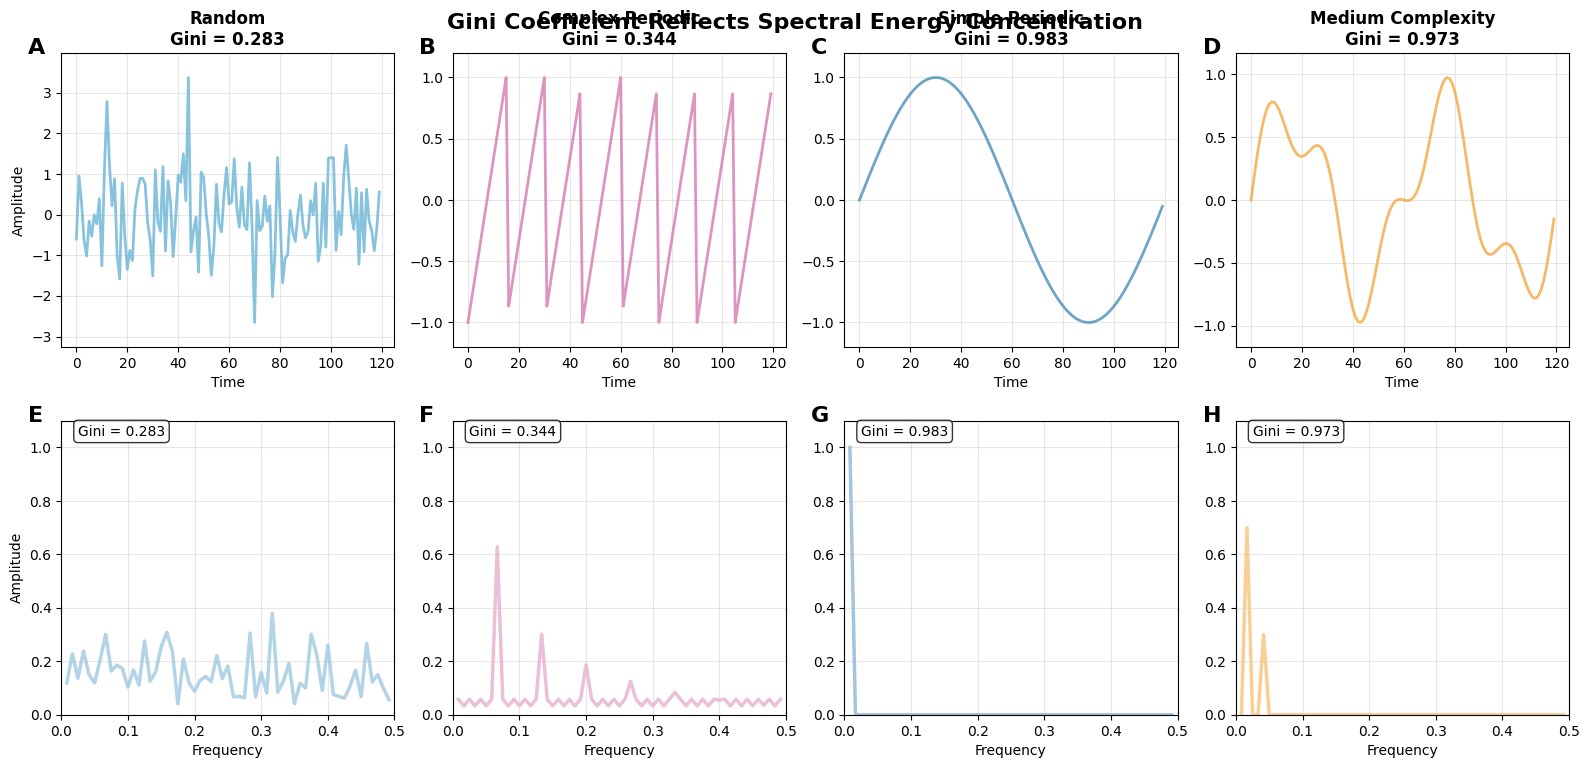

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy import signal
import os


def gini(x):
    """Compute Gini coefficient"""
    x = np.asarray(x, dtype=float).flatten()
    if np.sum(x) == 0:
        return 0.0
    if np.any(x < 0):
        x = x - np.min(x)
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (np.sum((2 * np.arange(1, n + 1) - n - 1) * x)) / (n * cumx[-1])


def plot_gini_concept_single(save_dir='./FigurePlot/GiniConcept/'):
    """
    Plot Gini coefficient concept figure - simplified version:
    Only show signal curves and spectra
    """
    # Data preparation
    n_cells = 120
    t = np.arange(n_cells)
    
    # Four types of signals
    # 1. Random signal (Gaussian noise)
    signal_rand = np.random.randn(n_cells)
    
    # 2. Complex periodic signal (sawtooth wave)
    k_base_complex = 8
    signal_complex = signal.sawtooth(2 * np.pi * k_base_complex * t / n_cells, width=1)
    
    # 3. Simple periodic signal (sine wave)
    signal_lf = np.sin(2 * np.pi * t / n_cells)
    
    # 4. Medium complexity signal (two frequencies combined)
    signal_medium = 0.7 * np.sin(2 * np.pi * 2 * t / n_cells) + 0.3 * np.sin(2 * np.pi * 5 * t / n_cells)

    # Function to compute spectrum and Gini coefficient
    def calculate_spectrum_and_gini(signal_data):
        n = len(signal_data)
        signal_centered = signal_data - np.mean(signal_data)
        yf = fft(signal_centered)
        amplitudes = 2.0/n * np.abs(yf[1:n//2])
        freqs = fftfreq(n, 1.0)[1:n//2]
        gini_score = gini(amplitudes)
        return freqs, amplitudes, gini_score

    # Compute spectra and Gini scores
    freqs_rand, amps_rand, gini_rand = calculate_spectrum_and_gini(signal_rand)
    freqs_complex, amps_complex, gini_complex = calculate_spectrum_and_gini(signal_complex)
    freqs_lf, amps_lf, gini_lf = calculate_spectrum_and_gini(signal_lf)
    freqs_medium, amps_medium, gini_medium = calculate_spectrum_and_gini(signal_medium)

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Color scheme
    colors = ['#6BB5D6', '#D67AB1', '#4A8FB8', '#F5A742']
    light_colors = ['#A0C8E0', '#E8B0D0', '#8CB8D6', '#F8C47D']
    
    # Maximum amplitude for spectra
    max_amp = max(np.max(amps_rand), np.max(amps_complex), np.max(amps_lf), np.max(amps_medium)) * 1.1

    # First row: signal curves
    signal_data = [
        (signal_rand, colors[0], f'Random\nGini = {gini_rand:.3f}'),
        (signal_complex, colors[1], f'Complex Periodic\nGini = {gini_complex:.3f}'),
        (signal_lf, colors[2], f'Simple Periodic\nGini = {gini_lf:.3f}'),
        (signal_medium, colors[3], f'Medium Complexity\nGini = {gini_medium:.3f}')
    ]
    
    for i, (signal_vals, color, title) in enumerate(signal_data):
        ax_signal = axes[0, i]
        ax_signal.plot(t, signal_vals, color=color, linewidth=2, alpha=0.8)
        ax_signal.set_title(title, fontweight='bold', fontsize=12)
        ax_signal.set_xlabel('Time')
        if i == 0:
            ax_signal.set_ylabel('Amplitude')
        ax_signal.grid(True, alpha=0.3)
        y_range = np.max(signal_vals) - np.min(signal_vals)
        if y_range > 0:
            ax_signal.set_ylim(np.min(signal_vals) - 0.1*y_range, np.max(signal_vals) + 0.1*y_range)

    # Second row: spectra
    spectra_data = [
        (freqs_rand, amps_rand, gini_rand, colors[0], light_colors[0]),
        (freqs_complex, amps_complex, gini_complex, colors[1], light_colors[1]),
        (freqs_lf, amps_lf, gini_lf, colors[2], light_colors[2]),
        (freqs_medium, amps_medium, gini_medium, colors[3], light_colors[3])
    ]
    
    for i, (freqs, amps, gini_val, color, line_color) in enumerate(spectra_data):
        ax_spec = axes[1, i]
        ax_spec.plot(freqs, amps, color=line_color, linewidth=2.5, alpha=0.8)
        ax_spec.set_xlabel('Frequency')
        if i == 0:
            ax_spec.set_ylabel('Amplitude')
        ax_spec.grid(True, alpha=0.3)
        ax_spec.set_xlim(0, 0.5)
        ax_spec.set_ylim(0, max_amp)
        ax_spec.text(0.05, 0.95, f'Gini = {gini_val:.3f}', 
                     transform=ax_spec.transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    # Add subplot labels
    for i, label in enumerate(['A', 'B', 'C', 'D']):
        axes[0, i].text(-0.1, 1.05, label, transform=axes[0, i].transAxes, 
                        fontsize=16, fontweight='bold', va='top')
        axes[1, i].text(-0.1, 1.05, chr(ord(label)+4), transform=axes[1, i].transAxes, 
                        fontsize=16, fontweight='bold', va='top')

    # Overall title
    plt.suptitle('Gini Coefficient Reflects Spectral Energy Concentration', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

    # Save figure (PNG only)
    os.makedirs(save_dir, exist_ok=True)
    png_path = os.path.join(save_dir, 'Gini_Concept_Plot_Clean.png')
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"Simplified Gini concept figure saved: {png_path}")
    
    plt.show()
    plt.close()


# Example usage
plot_gini_concept_single()


# Part1-4-Gini L Distribution Plotting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scanpy as sc
import seaborn as sns
from scipy import sparse
import warnings
import sys

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Configuration & Paths
# ==============================================================================

# Base directory for saving results
BASE_SAVE_DIR = './FigurePlot'
SUB_DIR = 'Gini_Analysis'
SAVE_DIR = os.path.join(BASE_SAVE_DIR, SUB_DIR)

# Ensure directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Results will be saved to: {SAVE_DIR}")

# Set plotting style (Publication Standard)
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans', 'sans-serif']
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.2

# Dataset Paths
DATASETS = {
    'mESC': './Dataset/mESC.h5ad',
    'hESC': './Dataset/hESC.h5ad',
    'hU2OS': './Dataset/hU2OS.h5ad',
    'mESCQ': './Dataset/mESCQ.h5ad' if os.path.exists('./Dataset/mESCQ.h5ad') else './Dataset/mESCQ'
}

# Number of top oscillating genes to analyze
TOP_N_GENES = 1000 

# ==============================================================================
# 2. Helper Functions
# ==============================================================================

def sort_by_cell_cycle(adata):
    """
    Sorts the AnnData object based on the ground truth cell cycle position.
    """
    print("    Sorting cells by cell cycle position...")
    
    # Identify the correct column for sorting
    target_col = None
    possible_cols = ['True', 'true', 'theta', 'phase_true']
    
    for col in possible_cols:
        if col in adata.obs.columns:
            target_col = col
            break
            
    if target_col:
        # Sort indices based on the target column
        sorted_indices = adata.obs.sort_values(by=target_col).index
        # Return a sorted view/copy
        return adata[sorted_indices].copy()
    else:
        print(f"    [Warning] None of {possible_cols} found in obs. Returning unsorted data.")
        return adata

def gini_coefficient(x):
    """
    Calculates the Gini coefficient for a spectral array.
    """
    x = np.asarray(x, dtype=np.float64).flatten()
    if np.any(x < 0): x = np.abs(x) # Handle potential negative values
    
    n = len(x)
    if n <= 1: return 0.0
    
    x = np.sort(x) # Sorting is essential for Gini
    s = np.sum(x)
    if s == 0: return 0.0
    
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x)) / (n * s) - (n + 1) / n

# ==============================================================================
# 3. Core Analysis Logic
# ==============================================================================

def process_single_dataset(dataset_name, file_path):
    print(f"\n[{dataset_name}] Processing...")
    
    # 1. Load Data
    if not os.path.exists(file_path):
        print(f"    [Error] File not found: {file_path}")
        return
    
    adata = sc.read(file_path)
    
    # 2. Sort Cells (Time-series requirement)
    adata = sort_by_cell_cycle(adata)
    
    # 3. Perform Global FFT to find Dominant Amplitude/Frequency for ALL genes
    print("    Performing FFT on all genes to identify top oscillators...")
    
    if sparse.issparse(adata.X):
        data_matrix = adata.X.toarray()
    else:
        data_matrix = adata.X
        
    n_cells = data_matrix.shape[0]
    
    # FFT along cell axis (axis=0)
    fft_results = np.fft.rfft(data_matrix, axis=0)
    freqs = np.fft.rfftfreq(n_cells)
    amplitudes = np.abs(fft_results)
    
    # Remove DC component (Index 0) for cleaner metrics
    amplitudes_no_dc = amplitudes[1:, :]
    
    # Find max amplitude and corresponding frequency for each gene
    max_amp_indices = np.argmax(amplitudes_no_dc, axis=0)
    dominant_amps = np.max(amplitudes_no_dc, axis=0)
    dominant_freqs = freqs[max_amp_indices + 1] # +1 offset because we removed DC
    
    # Store in metadata
    adata.var['dominant_amplitude'] = dominant_amps
    adata.var['dominant_frequency'] = dominant_freqs
    
    # 4. Subset Top N Genes (Target Adata)
    # Logic: Filter the top 1000 genes with the highest oscillation amplitude
    print(f"    Selecting top {TOP_N_GENES} genes by dominant amplitude...")
    
    top_genes = adata.var.sort_values(by='dominant_amplitude', ascending=False).head(TOP_N_GENES).index
    target_adata = adata[:, top_genes].copy()
    
    # 5. Calculate Gini Coefficient for these specific genes
    # Note: We need to re-extract the spectrum for these specific genes (or index from previous calculation)
    # Here, we recalculate Gini based on the subsetted amplitudes for clarity
    
    # Get the column indices corresponding to top genes
    # (Since we have target_adata, we can just grab the columns corresponding to it from the amplitude matrix)
    # However, since we subsetted adata, the order might have changed or we need to map back.
    # Easiest way: Re-run Gini on the subsetted matrix (it's fast) or index the large amplitude matrix.
    
    # Let's index the large amplitude matrix to save time
    # adata.var_names are the columns. We find indices of top_genes in adata.var_names
    gene_indices = [adata.var_names.get_loc(g) for g in top_genes]
    target_amplitudes = amplitudes_no_dc[:, gene_indices]
    
    print("    Calculating Gini coefficients for target genes...")
    gini_scores = np.apply_along_axis(gini_coefficient, 0, target_amplitudes)
    
    target_adata.var['gini'] = gini_scores
    
    # 6. Plotting
    plot_hexbin(target_adata, dataset_name)

# ==============================================================================
# 4. Plotting Function
# ==============================================================================

def plot_hexbin(target_adata, dataset_name):
    """
    Plots Dominant Frequency vs Gini Coefficient for the target subset.
    """
    df_plot = pd.DataFrame({
        'dominant_frequency': target_adata.var['dominant_frequency'],
        'gini': target_adata.var['gini']
    })
    
    # Drop NaNs
    df_plot = df_plot.dropna()
    
    # Theme settings
    sns.set_theme(style="white", font="Arial")
    
    try:
        g = sns.jointplot(
            data=df_plot,
            x='dominant_frequency',
            y='gini',
            kind="hex",
            color="#4CB391",  # Teal color
            height=6,
            ratio=5,
            joint_kws={'gridsize': 25, 'bins': 'log'} # gridsize adjusts hexagon size
        )
        
        # Labels
        g.fig.suptitle(f'{dataset_name}: Top {TOP_N_GENES} Oscillating Genes', y=1.02, fontsize=14, fontweight='bold')
        g.set_axis_labels('Dominant Frequency', 'Spectral Gini Coefficient', fontsize=12)
        
        # Save
        file_base = os.path.join(SAVE_DIR, f'{dataset_name}_Top{TOP_N_GENES}_Gini')
        
        plt.savefig(f"{file_base}.png", dpi=300, bbox_inches='tight')
        plt.close()
        
    except Exception as e:
        print(f"    [Error] Plotting failed: {e}")

# ==============================================================================
# 5. Main Execution
# ==============================================================================

if __name__ == "__main__":
    print("="*60)
    print("Starting Top-Oscillating Gene Spectral Analysis")
    print("="*60)
    
    for name, path in DATASETS.items():
        try:
            process_single_dataset(name, path)
        except Exception as e:
            print(f"  [Critical Error] Failed dataset {name}: {e}")
            import traceback
            traceback.print_exc()
            
    print("\nAll tasks completed.")

Results will be saved to: /root/Cycle/Github/FigurePlot/Gini_Analysis
Starting Top-Oscillating Gene Spectral Analysis

[mESC] Processing...
    Sorting cells by cell cycle position...
    Performing FFT on all genes to identify top oscillators...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


    Selecting top 1000 genes by dominant amplitude...
    Calculating Gini coefficients for target genes...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f


[hESC] Processing...
    Sorting cells by cell cycle position...
    Performing FFT on all genes to identify top oscillators...
    Selecting top 1000 genes by dominant amplitude...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


    Calculating Gini coefficients for target genes...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f


[hU2OS] Processing...
    Sorting cells by cell cycle position...
    Performing FFT on all genes to identify top oscillators...
    Selecting top 1000 genes by dominant amplitude...
    Calculating Gini coefficients for target genes...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f


[mESCQ] Processing...
    Sorting cells by cell cycle position...
    Performing FFT on all genes to identify top oscillators...
    Selecting top 1000 genes by dominant amplitude...
    Calculating Gini coefficients for target genes...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f


All tasks completed.
